# Drought exposure

A simple accepted measure for drought is the Standardized Precipitation Index (SPI).

Agnew, C.T., Using the SPI to identify drought, Drought Network News, 12, 6–12, 2000

propose SPI thresholds:

| SPI      | Category         |
|----------|------------------|
| >= -0.84 | Normal           | 
| < -0.84  | Moderate Drought |
| < -1.28  | Severe drought   | 
| < -1.65  | Extreme drought  |


For starters, use the NCAR global SPI file for 1949-2012. This means cutting off a bit relative to the 2015 cutoff for the other indicators, but saves re-generating an SPI from ERA (this would be desirable in the future).

Select the locations experiencing 'Severe' drought on the 3-month basis. Define the drought indicator as 'number of months in drought' for a given year.



In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy
from cartopy import crs

import geopandas as gpd 
from config import DATA_SRC,POP_DATA_SRC, ERA_MONTHLY_FILE, CLIMATOLOGY_FILE_RESAMP, SHAPEFILES_SRC
import weather_ecmwf
import util
import config

import climate_conversions
import population_tools


In [4]:
spi_file = DATA_SRC / 'weather' / 'spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc'

In [5]:
spi = xr.open_dataset(str(spi_file))

In [11]:
spi

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 768)
Coordinates:
  * time     (time) datetime64[ns] 1949-01-16 1949-02-15 1949-03-16 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    spi3     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    spi6     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    spi12    (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    date     (time) int32 194901 194902 194903 194904 194905 194906 194907 ...
Attributes:
    creation_date:  Wed Dec  4 16:56:53 MST 2013
    reference:      McKee, T.B., N.J. Doesken, and J. Kleist, 1993. The \nrel...
    comment:        The SPI was developed by Tom McKee, Nolan Doesken, and\n ...
    Conventions:    CF
    institution:    National Center for Atmospheric Research (NCAR)
    source:         Land surface precipitation inte

In [ ]:
spi.spi3.mean(dim=['lat','lon']).plot()

In [34]:
droughts = spi.spi3.where(spi.spi3 < -1.28)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [35]:
droughts = droughts.groupby('time.year').count(dim='time')
droughts = droughts.astype(np.float64)
droughts.name = 'n_severe_drought'

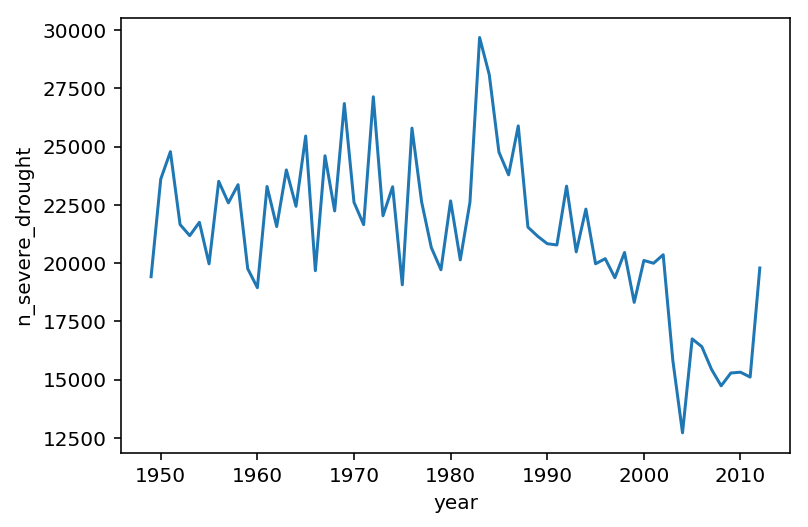

In [36]:
droughts.sum(dim=['lat', 'lon']).plot()

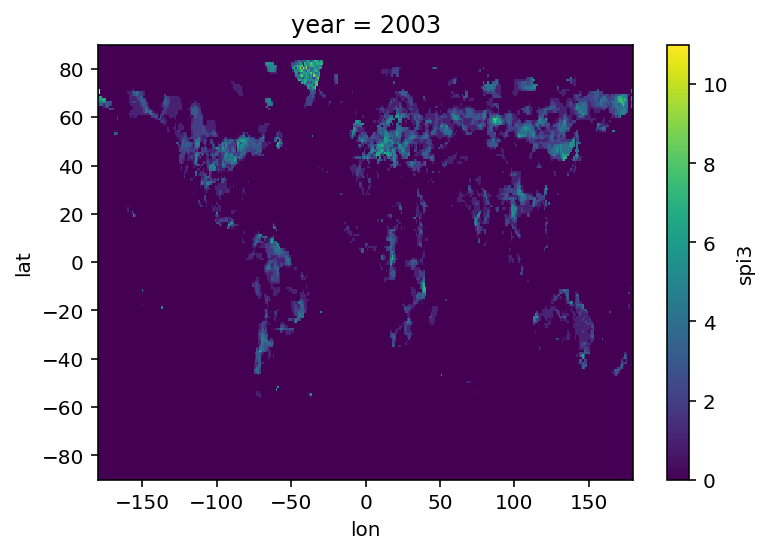

In [23]:
droughts.sel(year=2003).plot()

In [37]:
def get_drought_projection(droughts):
    with population_tools.PopulationProjector() as pop:
        years = list(range(2000,2013))
        def _gen():
            for year in years:
                print(year)
                yield pop.project(year, droughts.sel(year=year))
        droughts_pop = xr.concat(_gen(), dim='time')
        pop_sum = pop.data.population.sum(dim=['latitude', 'longitude'])
        return droughts_pop.compute(), pop_sum.compute()
    
droughts_pop, pop_sum = get_drought_projection(droughts)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [28]:
droughts_pop_ts = (droughts_pop / pop_sum).sum(dim=['latitude', 'longitude'])


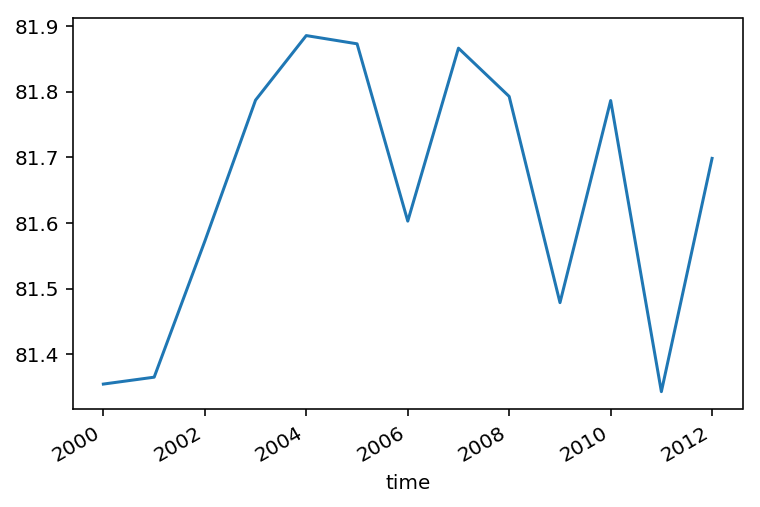

In [29]:
droughts_pop_ts.plot()